In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import cv2
import numpy as np
from PIL import Image
import os

import heapq
import itertools
from sklearn.decomposition import PCA

In [2]:
test_dir = 'data/merged/test/'
train_dir = 'data/merged/train/'

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(classes)

In [3]:
print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 7 
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
print("--------Train--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(train_dir + cls))}')

print("\n--------Test--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(test_dir + cls))}')
    
#print("\n--------balance--------")
## check the number of images in each class
#for cls in classes:
#    print(f'{cls}: {len(os.listdir(b_train_dir + cls))}')

--------Train--------
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171

--------Test--------
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


In [5]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

print("--------Train--------")
delete_irrelevant_files(train_dir, classes)

print("\n--------Test--------")
delete_irrelevant_files(test_dir, classes)

#delete_irrelevant_files(b_train_dir, classes)


/var/folders/4_/9bsstmy967q8y63k9rwn4g6r0000gn/T/ipykernel_70906/562769059.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


--------Train--------

--------Test--------

--------Test--------


# Landmark detection from images and correlation of those landmark positions

In [6]:
image_size = torch.Size([48, 48, 3])
batch_size = 128

# Compute the total size of the image input
image_input_size = np.prod(image_size) * batch_size * 4. / (1024 ** 2.)
print(f"Image input size: {image_input_size:.2f} MB")

Image input size: 3.38 MB


In [7]:
class FER_Dataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Keep a deterministic, sorted class order shared by train/val
        self.classes = sorted(classes)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for img_name in sorted(os.listdir(class_dir)):
                img_path = os.path.join(class_dir, img_name)
                # Lazy load; just store the path and label index
                if os.path.isfile(img_path):
                    self.samples.append((img_path, self.class_to_idx[label]))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        trials = 0
        while trials < 3:
            img_path, label = self.samples[idx]
            assert 0 <= label < len(self.classes), "Label index out of range"
            image = cv2.imread(img_path)
            if image is None:
                trials += 1
                idx = (idx + 1) % len(self.samples)
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)
            if self.transform:
                image = self.transform(image)
            return image, label
        raise RuntimeError(f"Failed to read image after retries starting at index {idx}: {img_path}")

In [8]:
# Train/val transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03), scale=(0.95, 1.05), shear=3),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), ratio=(0.5, 2.0)),
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = FER_Dataset(train_dir, classes=classes, transform=train_transform)
val_dataset = FER_Dataset(test_dir, classes=classes, transform=val_transform)

In [9]:
# Dataloaders will be defined after class weights to attach the sampler.
train_dataloader = None
val_dataloader = None

In [10]:
if train_dataloader is not None and val_dataloader is not None:
    for i, data in enumerate(train_dataloader):
        print(i, data[0].shape, data[1].shape)
        break
    for i, data in enumerate(val_dataloader):
        print(i, data[0].shape, data[1].shape)
        break
else:
    print("Run the dataloader setup cell after class weights to initialize loaders before checking shapes.")

# torch.Size([256, 3, 48, 48]) torch.Size([4])


Run the dataloader setup cell after class weights to initialize loaders before checking shapes.


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

        self.fc = nn.Linear(input_dim, input_dim)

    def scaled_dot_product_attention(self, query, key, value):
        qk = torch.matmul(query, key.transpose(-2, -1))
        dk = query.size(-1)
        scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.transpose(1, 2)

    def forward(self, x):
        batch_size = x.size(0)

        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)

        out, attention_weights = self.scaled_dot_product_attention(query, key, value)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.input_dim)

        out = self.fc(out)
        
        return out

In [12]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=8, spatial_kernel=7):
        super().__init__()
        self.channel_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid(),
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=spatial_kernel, padding=spatial_kernel // 2, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Channel attention
        ca = self.channel_mlp(x)
        x = x * ca
        # Spatial attention
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        mean_pool = torch.mean(x, dim=1, keepdim=True)
        sa = self.spatial(torch.cat([max_pool, mean_pool], dim=1))
        return x * sa

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, Seq, Dim)
        attn_out = self.attention(x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        ff_out = self.feed_forward(x)
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        return x

class HybridViTExpressionModel(nn.Module):
    def __init__(self, num_classes, embed_dim=192, num_heads=4, depth=1, freeze_stages=3, dropout=0.5):
        super().__init__()
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        backbone = efficientnet_b0(weights=weights)
        self.backbone = backbone.features
        self.backbone_out_channels = 1280
        
        # Freeze early stages to retain pretrained low-level features
        for idx, block in enumerate(self.backbone):
            if idx < freeze_stages:
                for param in block.parameters():
                    param.requires_grad = False
        
        self.cbam = CBAM(self.backbone_out_channels)
        self.proj = nn.Linear(self.backbone_out_channels, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        # Use custom TransformerBlock instead of nn.TransformerEncoderLayer for CoreML compatibility
        self.transformer = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        feats = self.backbone(x)
        feats = self.cbam(feats)
        b, c, h, w = feats.shape
        tokens = feats.flatten(2).transpose(1, 2)  # (B, HW, C)
        tokens = self.proj(tokens)
        tokens = self.proj_drop(tokens)
        tokens = self.transformer(tokens)
        tokens = self.norm(tokens)
        pooled = tokens.mean(dim=1)
        logits = self.classifier(pooled)
        return logits

In [14]:
mps_ok = torch.backends.mps.is_available()
cuda_ok = torch.cuda.is_available()
device = torch.device("mps" if mps_ok else ("cuda" if cuda_ok else "cpu"))
print(f"Using device: {device}")

Using device: mps


In [15]:
num_classes = 7
embed_dim = 192
num_heads = 4
transformer_depth = 1

In [16]:
# Ensure model exists before saving architecture snapshot
if 'model' not in locals():
    model = HybridViTExpressionModel(num_classes, embed_dim=embed_dim, num_heads=num_heads, depth=transformer_depth).to(device)

with open('Architecture/HybridViTExpressionModel.txt', 'w') as f:
    f.write(str(model))

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device, max_grad_norm=1.0, scaler=None, mixup_alpha=0.0, mixup_prob=0.0):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0  # Use float to handle mixup weighted accuracy

    # Only autocast on CUDA to avoid fp16 issues on MPS/CPU
    use_autocast = torch.device(device).type == "cuda"
    autocast_dtype = torch.float16 if use_autocast else torch.float32

    for data, targets in dataloader:
        data = data.to(device)
        targets = targets.to(device)
        
        # Apply mixup with probability mixup_prob
        apply_mixup = mixup_alpha > 0 and np.random.rand() < mixup_prob
        if apply_mixup:
            data, targets_a, targets_b, lam = mixup_data(data, targets, mixup_alpha)

        if use_autocast:
            with torch.amp.autocast(device_type="cuda", dtype=autocast_dtype):
                outputs = model(data)
                if apply_mixup:
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                else:
                    loss = criterion(outputs, targets)
        else:
            outputs = model(data)
            if apply_mixup:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, 1)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item() * data.size(0)
        # For mixup, accuracy is approximate (weighted sum of matches)
        if apply_mixup:
            correct_a = (preds == targets_a).sum().item()
            correct_b = (preds == targets_b).sum().item()
            running_corrects += lam * correct_a + (1 - lam) * correct_b
        else:
            running_corrects += (preds == targets).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [18]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    use_autocast = torch.device(device).type == "cuda"
    autocast_dtype = torch.float16 if use_autocast else torch.float32

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            if use_autocast:
                with torch.amp.autocast(device_type="cuda", dtype=autocast_dtype):
                    outputs = model(data)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * data.size(0)
            running_corrects += torch.sum(preds == targets.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.float() / float(len(dataloader.dataset))

    return epoch_loss, epoch_acc

In [19]:
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import WeightedRandomSampler 

# Class weighting for imbalance
eps = 1e-6
class_counts = torch.tensor([len(os.listdir(os.path.join(train_dir, cls))) for cls in classes], device="cpu", dtype=torch.float)
class_weights = (class_counts.sum() / (class_counts + eps)).float()
class_weights = class_weights / class_weights.mean()

# ---------- ANTI-OVERFITTING HYPERPARAMETERS ----------
base_lr = 2e-4           # Slightly lower LR
weight_decay = 5e-3      # Stronger L2 regularization
warmup_epochs = 3        # Shorter warmup
num_epochs = 60          # Fewer epochs (early stopping will kick in)
dropout = 0.5            # Higher dropout (passed to model)
mixup_alpha = 0.2        # Mixup augmentation strength
mixup_prob = 0.5         # Probability of applying mixup per batch
# -------------------------------------------------------

model = HybridViTExpressionModel(num_classes, embed_dim=embed_dim, num_heads=num_heads, depth=transformer_depth, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=max(num_epochs - warmup_epochs, 1), eta_min=1e-6)
scaler = GradScaler(enabled=device.type == "cuda")

# Mixup utility function
def mixup_data(x, y, alpha=0.2):
    """Apply mixup augmentation to a batch."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

/var/folders/4_/9bsstmy967q8y63k9rwn4g6r0000gn/T/ipykernel_70906/4179510005.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=device.type == "cuda")


In [20]:
sample_weights = torch.tensor([class_weights[label] for _, label in train_dataset.samples], dtype=torch.double)
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
print(device)

mps


In [22]:
import matplotlib.pyplot as plt
import builtins

# create empty lists to store loss and accuracy for each epoch
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

max_grad_norm = 1.0
early_stop_patience = 15  # Tighter early stopping
best_val_loss = float("inf")
no_improve_epochs = 0

device_type = torch.device(device).type

if not hasattr(builtins, "_fer_training_started"):
    builtins._fer_training_started = True

    run_id = torch.randint(0, 1_000_000, ()).item()
    print(f"Starting training run_id={run_id}")
    print(f"Overfitting mitigations: dropout={dropout}, weight_decay={weight_decay}, mixup_alpha={mixup_alpha}, mixup_prob={mixup_prob}, epochs={num_epochs}, early_stop={early_stop_patience}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model, train_dataloader, criterion, optimizer, device, 
            max_grad_norm=max_grad_norm, scaler=scaler,
            mixup_alpha=mixup_alpha, mixup_prob=mixup_prob
        )
        val_loss, val_acc = validate_epoch(model, val_dataloader, criterion, device)
        
        # Warmup then cosine schedule
        if epoch < warmup_epochs:
            warmup_lr = base_lr * float(epoch + 1) / float(warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        else:
            cosine_scheduler.step()
        
        # append the loss and accuracy to the lists
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"[run_id={run_id}] Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")

        # Early stopping on validation loss
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            no_improve_epochs = 0
            # Save best model checkpoint
            torch.save(model.state_dict(), "best_model.pth")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model after training
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", weights_only=True))
        print("Loaded best model checkpoint.")
else:
    print("Training already started in this kernel; restart kernel to run again.")

Starting training run_id=806842
Overfitting mitigations: dropout=0.5, weight_decay=0.005, mixup_alpha=0.2, mixup_prob=0.5, epochs=60, early_stop=15
[run_id=806842] Epoch: 1/60, Train Loss: 1.1218, Train Acc: 0.2601, Val Loss: 2.1823, Val Acc: 0.3454, LR: 0.000067
[run_id=806842] Epoch: 1/60, Train Loss: 1.1218, Train Acc: 0.2601, Val Loss: 2.1823, Val Acc: 0.3454, LR: 0.000067
[run_id=806842] Epoch: 2/60, Train Loss: 0.8770, Train Acc: 0.4433, Val Loss: 1.9646, Val Acc: 0.4713, LR: 0.000133
[run_id=806842] Epoch: 2/60, Train Loss: 0.8770, Train Acc: 0.4433, Val Loss: 1.9646, Val Acc: 0.4713, LR: 0.000133
[run_id=806842] Epoch: 3/60, Train Loss: 0.8270, Train Acc: 0.5086, Val Loss: 1.8707, Val Acc: 0.5183, LR: 0.000200
[run_id=806842] Epoch: 3/60, Train Loss: 0.8270, Train Acc: 0.5086, Val Loss: 1.8707, Val Acc: 0.5183, LR: 0.000200
[run_id=806842] Epoch: 4/60, Train Loss: 0.8028, Train Acc: 0.5529, Val Loss: 1.8711, Val Acc: 0.5646, LR: 0.000200
[run_id=806842] Epoch: 4/60, Train Loss:

In [23]:
import torch
import torch.onnx

device = next(model.parameters()).device
dummy_input = torch.randn(1, 3, 128, 128).to(device)

onnx_filename = "FER_Model_Adam.onnx"
torch.onnx.export(model, dummy_input, onnx_filename)

print(f"Model saved as {onnx_filename}")

[torch.onnx] Obtain model graph for `HybridViTExpressionModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `HybridViTExpressionModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Obtain model graph for `HybridViTExpressionModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 102 of general pattern rewrite rules.
Model saved as FER_Model_Adam.onnx
Applied 102 of general pattern rewrite rules.
Model saved as FER_Model_Adam.onnx


In [25]:
import coremltools as ct

# Now that we use a custom TransformerBlock (standard ops), we can convert directly from PyTorch.
model.eval()
model_cpu = model.to("cpu")
example = torch.randn(1, 3, 128, 128)

# Trace the model
traced = torch.jit.trace(model_cpu, example)

# Convert to CoreML
mlmodel = ct.convert(
    traced,
    inputs=[ct.ImageType(name="image", shape=example.shape, scale=1/127.5, bias=[-1.0, -1.0, -1.0], color_layout="RGB")],
    minimum_deployment_target=ct.target.iOS15,
    convert_to="mlprogram"
)

# Save as .mlpackage for ML Program format
mlmodel.save("FER_Model.mlpackage")
model.to(device)
print("Model saved as FER_Model.mlpackage")

/var/folders/4_/9bsstmy967q8y63k9rwn4g6r0000gn/T/ipykernel_70906/940063433.py:17: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))
/var/folders/4_/9bsstmy967q8y63k9rwn4g6r0000gn/T/ipykernel_70906/940063433.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_attention_logits = qk / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=qk.device))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 274.24 passes/s]


Model saved as FER_Model.mlpackage


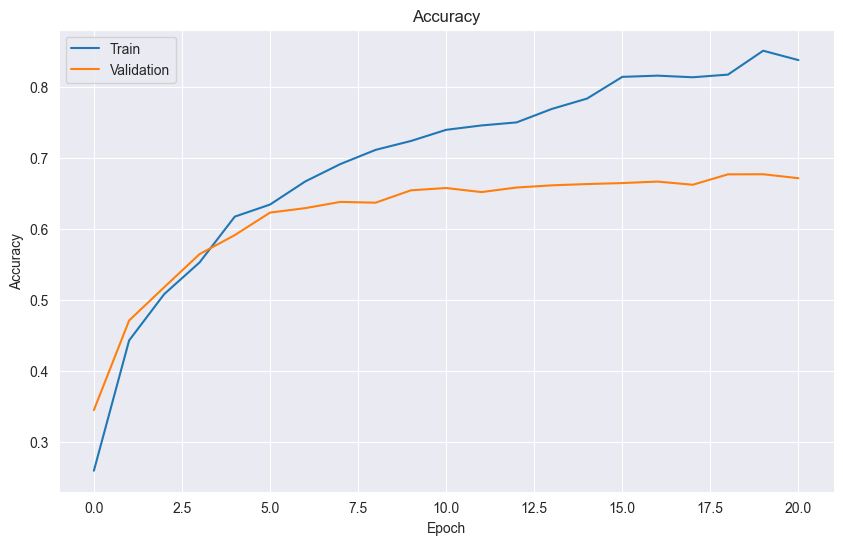

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_acc_list = [float(t) for t in train_acc_list]
val_acc_list = [float(t) for t in val_acc_list]

train_acc_df = pd.DataFrame({'Epoch': range(len(train_acc_list)), 'Accuracy': train_acc_list, 'Type': 'Train'})
val_acc_df = pd.DataFrame({'Epoch': range(len(val_acc_list)), 'Accuracy': val_acc_list, 'Type': 'Validation'})

acc_df = pd.concat([train_acc_df, val_acc_df])

sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Accuracy', hue='Type')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the graph to a file
plt.savefig('accuracy_graph_Adam.png', dpi=300)

plt.show()


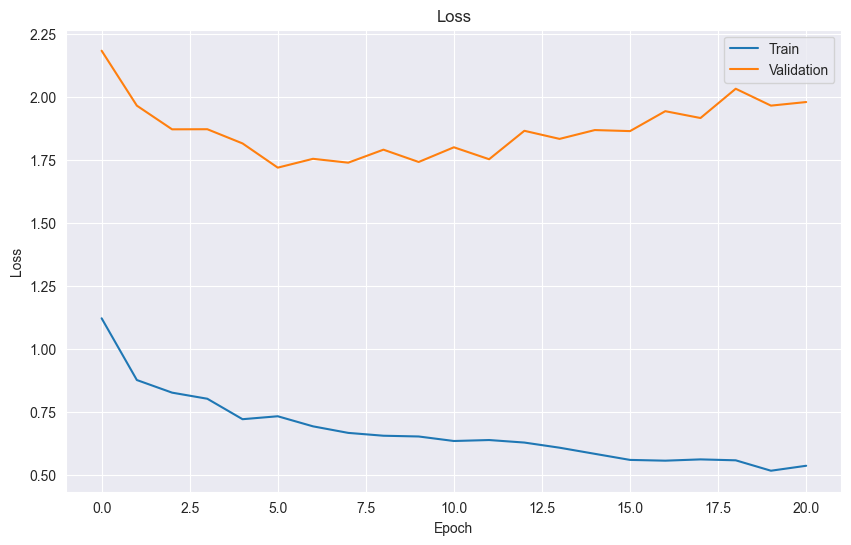

In [27]:
train_loss_list = [float(t) for t in train_loss_list]
val_loss_list = [float(t) for t in val_loss_list]

train_loss_list = pd.DataFrame({'Epoch': range(len(train_loss_list)), 'Loss': train_loss_list, 'Type': 'Train'})
val_loss_list = pd.DataFrame({'Epoch': range(len(val_loss_list)), 'Loss': val_loss_list, 'Type': 'Validation'})

acc_df = pd.concat([train_loss_list, val_loss_list])

sns.set_style('darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Loss', hue='Type')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the graph to a file
plt.savefig('loss_graph_Adam.png', dpi=300)

plt.show()


In [28]:
# define a function to check pytorch version
def check_pytorch_version():
    if torch.__version__ >= '1.6.0':
        return True
    else:
        return False
    
# define a function to check cuda version
def check_cuda_version():
    if torch.cuda.is_available():
        return True
    else:
        return False
    
# define a function to check cudnn version
def check_cudnn_version():
    if check_cuda_version():
        if torch.backends.cudnn.enabled:
            return True
        else:
            return False
    else:
        return False
    
# define a function to check if the system is ready for training
def check_system():
    if check_pytorch_version():
        print('PyTorch version: {}'.format(torch.__version__))
    else:
        print('PyTorch version: {} (update required)'.format(torch.__version__))
        
    if check_cuda_version():
        print('CUDA version: {}'.format(torch.version.cuda))
    else:
        print('CUDA version: {} (install CUDA to enable GPU training)'.format(torch.version.cuda))
        
    if check_cudnn_version():
        print('cuDNN version: {}'.format(torch.backends.cudnn.version()))
    else:
        print('cuDNN version: {} (install cuDNN to enable GPU training)'.format(torch.backends.cudnn.version()))

check_system()

PyTorch version: 2.9.1
CUDA version: None (install CUDA to enable GPU training)
cuDNN version: None (install cuDNN to enable GPU training)


## Plan: MediaPipe Landmarks + Feature Fusion
- Extract 468-point face mesh (x, y, z) with MediaPipe during data loading; cache to disk to avoid recompute.
- Build geometric features: per-point normalized coords, eye/mouth aspect ratios, distances to nose tip, angles for eyebrows/mouth corners, and temporal deltas if using video.
- Create a small MLP branch (e.g., Linear->GELU->Dropout) to embed landmark features, then concatenate with the CNN-Transformer pooled embedding before the final classifier.
- Normalize landmarks per face (center to nose tip, scale by inter-ocular distance) to reduce variance across subjects.
- For inference, run MediaPipe once per frame, reuse the same ring buffer to smooth both pixel and landmark branches, then fuse and classify.
- Efficiency: MediaPipe on CPU is typically <3 ms on laptop CPUs; the fused model keeps the vision backbone unchanged, so latency overhead is modest while adding strong pose/shape cues.